# Exploration-Exploitation Tradeoff
### Yabra Muvdi

## 0. Setup

Running the entire notebook reproduces Figure 1 from [Chapelle & Li (2011)](https://papers.nips.cc/paper/4321-an-empirical-evaluation-of-thompson-sampling.pdf). The notebook contains several intermediate tests but they are all commented out.

In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

## 1. Implementation of the Thompson Sampling Algorithm

In [2]:
def thompson_sampling(iterations, k, alpha, beta, epsilon):
    """ implementation of a Thompson sampling algorithm for the
        K-armed Bernoulli bandit problem. Given that the reward in
        each arm is given by a Bernoulli distritubion, it is natural
        to  select as a prior the Beta distribution

        Args:
            1. iterations: number of iterations to perform
            2. k: number of arms in the problem
            3. alpha: parameter of Beta distribution
            4. beta: parameter of Beta distribution
            5. epsilon: deviation from the reward probability of 
            the best arm

        Returns:
            1. cum_regret: list containing the cumulative regret at each iteration
            2. thetas: list containing the estimated parameter for
            each Bernoulli arm
            3. actions: list containing the action taken at each iteration

    """
    
    # initialize counters of success and failure for all arms
    success = [0]*k
    failure = [0]*k

    # initialize a list to store the regret and actions at each iteration
    cum_regret = [0]
    actions = []
    
    # select best arm!
    best_arm = np.random.randint(0,k)
    print('Arm ', best_arm, ' is the best one!')

    for t in range(1,iterations):
        # initialize a list to store the Bernoulli parameters (theta)
        thetas = []
        # iterate over all arms
        for i in range(k):
            # draw theta from Beta distribution
            thetas.append(np.random.beta(success[i] + alpha,
                                         failure[i] + beta))

        # choose arm with the highest probability
        choosen_arm = np.argmax(thetas)
        actions.append(choosen_arm)
        
        # get reward from choosen arm
        if choosen_arm == best_arm:
            reward = np.random.binomial(1, 0.5)
            regret = cum_regret[t-1]
        else:
            reward = np.random.binomial(1, 0.5 - epsilon)
            regret = cum_regret[t-1] + epsilon

        # store cumulative regret
        cum_regret.append(regret)
        
        # evaluate decision
        if reward == 1:
            success[choosen_arm] += 1
        else:
            failure[choosen_arm] += 1


    return(cum_regret, thetas, actions)    

In [7]:
# # define parameters of the algorithm for a test run
# k = 10
# alpha = 1
# beta = 1
# iterations = 1000000
# epsilon = 0.02

In [8]:
# cum_regret, thetas, actions = thompson_sampling(iterations,k,alpha,beta,epsilon)

Arm  4  is the best one!


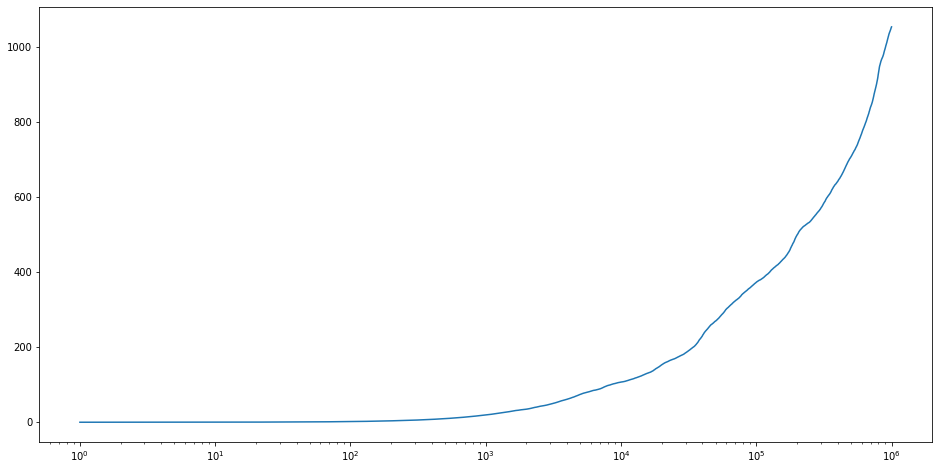

In [9]:
# plt.figure(figsize=(16,8))
# plt.plot(list(range(1,iterations)), cum_regret[1:iterations])
# plt.xscale('log')
# plt.show()

In [3]:
def meta_thompson_sampling(iterations_sampler, k, alpha, beta, epsilon, simulations):
    """ a function to simulate several times a Thompson sampling algorithm

        Args:
            1. iterations: number of iterations to perform
            2. k: number of arms in the problem
            3. alpha: parameter of Beta distribution
            4. beta: parameter of Beta distribution
            5. epsilon: deviation from the reward probability of 
            the best arm
            6. simulations: number of simulations to perform

        Returns:
            1. avg_cum_regrets: list containing the average cumulative regret at each iteration
            2. avg_thetas: list containing the average estimated parameter for each Bernoulli arm
    """
    
    all_regrets = []
    all_thetas = []
    
    for i in range(simulations):
        # run Thompson's sampling algorithm
        cum_regret, thetas, actions = thompson_sampling(
            iterations_sampler, k, alpha, beta, epsilon)
        
        # store results
        all_regrets.append(np.array(cum_regret))
        all_thetas.append(np.array(thetas))
    
    avg_cum_regrets = np.mean(all_regrets, axis=0)
    avg_thetas = np.mean(all_thetas, axis=0)
    
    return(avg_cum_regrets, avg_thetas)

In [12]:
# # define parameters of the algorithm
# k = 10
# alpha = 1
# beta = 1
# iterations = 1000000
# epsilon = 0.02
# simulations = 10

In [13]:
# regrets, thetas = meta_thompson_sampling(iterations,k,alpha,beta,epsilon,simulations)

Arm  4  is the best one!
Arm  5  is the best one!
Arm  6  is the best one!
Arm  1  is the best one!
Arm  1  is the best one!
Arm  3  is the best one!
Arm  5  is the best one!
Arm  9  is the best one!
Arm  6  is the best one!
Arm  2  is the best one!


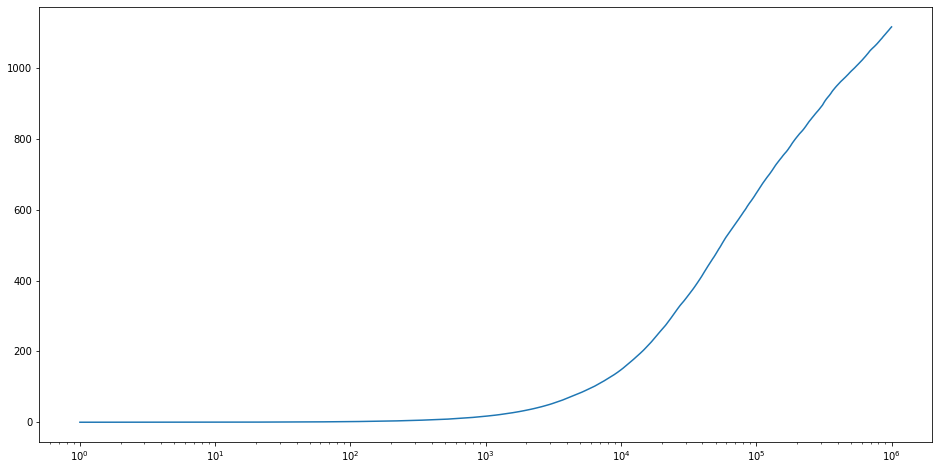

In [14]:
# plt.figure(figsize=(16,8))
# plt.plot(list(range(1,iterations)), regrets[1:iterations])
# plt.xscale('log')
# plt.show()

## 2. Implementation of the Upper Confidence Bounds (UCB) Algorithm

In [4]:
def UCB(iterations, k, epsilon):
    """ implementation of the Upper Confidence Bound algorithm for the
        K-armed Bernoulli bandit problem as formulated in Chapelle & Li (2011)

        Args:
            1. iterations: number of iterations to perform
            2. k: number of arms in the problem
            3. epsilon: deviation from the reward probability of 
            the best arm

        Returns:
            1. cum_regret: list containing the cumulative regret at each iteration
            2. actions: list containing the action taken at each iteration

    """
    
    # 1. setup
        
    # select best arm!
    best_arm = np.random.randint(0,k)
    print('Arm ', best_arm, ' is the best one!')
    
    # initialize a list to store the cumulative regret and actions at each iteration
    cum_regret = [0]*iterations
    actions = [0]*iterations
    
    # play each machine once to initialize rewards
    rewards = [[] for arm in range(k)]
    for arm in range(k):
        # get reward
        if arm == best_arm:
            rewards[arm].append(np.random.binomial(1, 0.5)) 
        else:
            rewards[arm].append(np.random.binomial(1, 0.5-epsilon))
    
    # initialize a list storing the average rewards
    avg_rewards = [reward[0] for reward in rewards]
    
    # initialize a counter for the number of times an action has been taken
    # we have already played each arm once, so we will start all arms with 1
    n_actions = [1]*k
    
    # 2. start looping...
    for t in range(1,iterations):
        
        # 3. calculate the estimated value for each arm        
        estimated_values = []
        for i, arm in enumerate(rewards):
            
            r = avg_rewards[i]
            m = n_actions[i]
            delta = math.sqrt(1/t)
            
            value = r + math.sqrt( (2*r*math.log(1/delta))/m ) + (2*math.log(1/delta))/m
            estimated_values.append(value)
        

        # 4. choose arm with the highest estimated value
        choosen_arm = np.argmax(estimated_values)
        actions[t] = choosen_arm
        
        # get reward from choosen arm
        if choosen_arm == best_arm:
            reward = np.random.binomial(1, 0.5)
            regret = cum_regret[t-1]
        else:
            reward = np.random.binomial(1, 0.5 - epsilon)
            regret = cum_regret[t-1] + epsilon

        # store reward
        rewards[choosen_arm].append(reward)
        
        # store cumulative regret
        cum_regret[t] = regret
        
        # increase the counter for the choose arm
        n_actions[choosen_arm] += 1
        
        # update the average reward
        avg_rewards[choosen_arm] = avg_rewards[choosen_arm] + ((reward-avg_rewards[choosen_arm])/n_actions[choosen_arm])


    return(cum_regret, actions)    

In [16]:
# # define parameters of the algorithm
# k = 10
# iterations = 10**7
# epsilon = 0.02

In [17]:
# cum_regret, actions = UCB(iterations, k, epsilon)

Arm  6  is the best one!


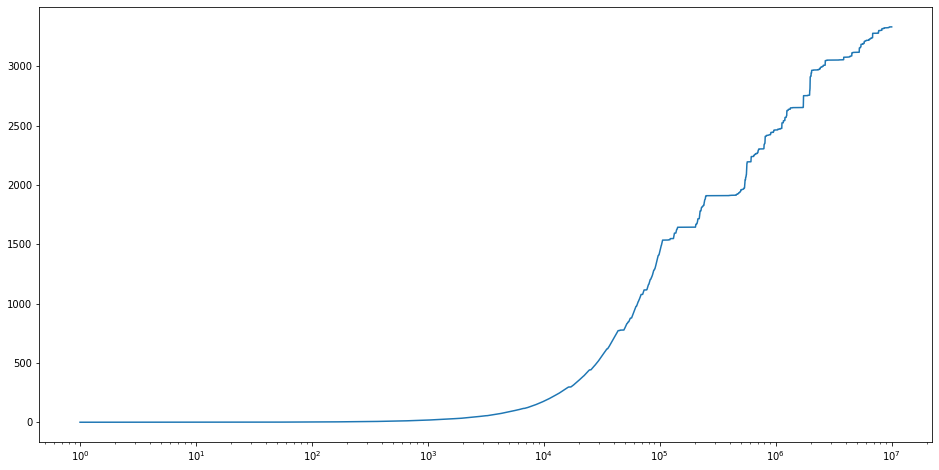

In [18]:
# plt.figure(figsize=(16,8))
# plt.plot(list(range(1,iterations)), cum_regret[1:iterations])
# plt.xscale('log')
# plt.show()

In [5]:
def meta_UCB(iterations_sampler, k, epsilon, simulations):
    """ a function to simulate several times a UCB algorithm

        Args:
            1. iterations: number of iterations to perform
            2. k: number of arms in the problem
            3. epsilon: deviation from the reward probability of 
            the best arm
            4. simulations: number of simulations to perform

        Returns:
            1. avg_cum_regrets: list containing the average cumulative regret at each iteration
    """
    
    all_regrets = []
    
    for i in range(simulations):
        # run UCB
        cum_regret, actions = UCB(iterations_sampler, k, epsilon)
        
        # store results
        all_regrets.append(np.array(cum_regret))
    
    avg_cum_regrets = np.mean(all_regrets, axis=0)
    
    return(avg_cum_regrets)

In [7]:
# # define parameters of the algorithm
# k = 10
# iterations = 10**7
# epsilon = 0.02
# simulations = 5

In [8]:
# cum_regret = meta_UCB(iterations, k, epsilon, simulations)

Arm  1  is the best one!
Arm  1  is the best one!
Arm  5  is the best one!
Arm  0  is the best one!
Arm  9  is the best one!


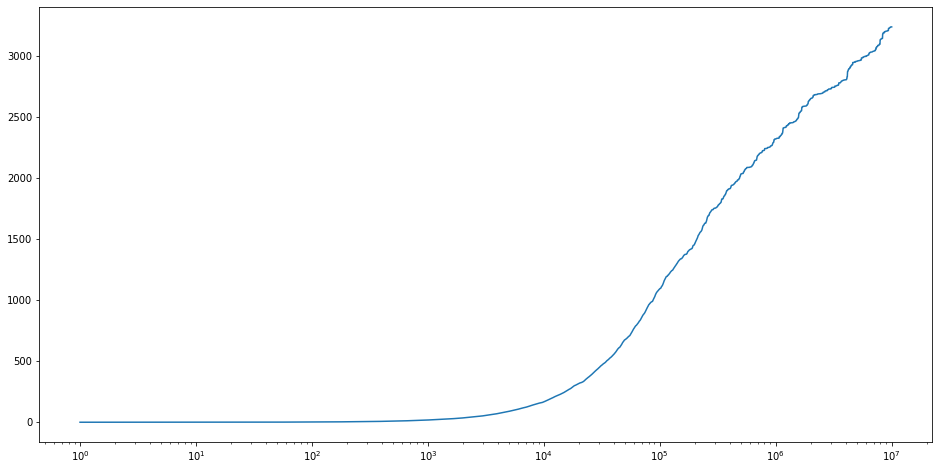

In [9]:
# plt.figure(figsize=(16,8))
# plt.plot(list(range(1,iterations)), cum_regret[1:iterations])
# plt.xscale('log')
# plt.show()

## 3. Lower bound

### 3.1. Derivation

We know that an assymptotic lower bound for the cumulative regret is given by:

$$ R(T) \geq  \log{(T)} \left ( \sum_{i=1}^{K} \frac{p^\star - p_i)}{KL(p_i \parallel p^\star)} + o(1) \right )   $$

Given that in our case we are dealing with Bernoulli distributions, we calculate their KL divergence. If $p_1$ and $p_2$ are two Bernoulli distributions with parameter $\theta_1$ and $\theta_2$ respectively then:

$$ KL(p_1 \parallel p_2) = E_{p_1} \left [\log{\frac{p_1(x)}{p_2(x)}} \right ] $$

$$ = E_{p_1} \left [\log{\frac{\theta_1^{x} (1-\theta_1)^{(1-x)}}{\theta_2^{x} (1-\theta_2)^{(1-x)}}} \right ]  $$

$$ = E_{p_1} \left [   x \log{ \frac{\theta_1}{\theta_2} } + (1-x)\log{ \frac{1-\theta_1}{1-\theta_2} } \right ] $$

Given that we are taking the expected value with respect to $p_1$ we know that $E_{p_1} \left [x \right ] =  \theta_1$ and consequently:

$$ = \theta_1 \log{ \frac{\theta_1}{\theta_2} } + (1-\theta_1)\log{ \frac{1-\theta_1}{1-\theta_2} } $$

Finally, we also know the values for $\theta_1$ and $\theta_2$ for our particular problem. In our case, $\theta_1 = 0.5 - \epsilon $ corresponds to the parameter of the distribution of the sub-optimal arms and $\theta_2 = 0.5 $ correspond to the parameter of the distribution of the optimal arm. Substituting this in the equation we get:

$$ KL(p_1 \parallel p_2) = (0.5 - \epsilon) \log{ \frac{0.5-\epsilon}{0.5} } + (0.5 + \epsilon)\log{ \frac{0.5 + \epsilon}{0.5} }  $$

Finally, putting everything together into the assymptotic lower bound we get:

$$ R(T) \geq \log{T} \sum_{i=1}^{K} \frac{0.5 - (0.5 - \epsilon)}{(0.5 - \epsilon) \log{ \frac{0.5-\epsilon}{0.5} } + (0.5 + \epsilon)\log{ \frac{0.5 + \epsilon}{0.5} }}  $$

As we also know that there is only one optimal bandit, we can further reduce the expression to:

$$ R(T) \geq \log{(T)} \left [ \frac{(K - 1)\epsilon}{(0.5 - \epsilon) \log{ \frac{0.5-\epsilon}{0.5} } + (0.5 + \epsilon)\log{ \frac{0.5 + \epsilon}{0.5} }} \right ] $$

In order to match the figures in Chapelle & Li (2011) we need to shift this bound so that when $ T = 10^2 $ we have $R(T) = 0$. This we can simply achieve by substracting the following to the optimal bound:

$$ shift =  \frac{\log{(10^2)}(K - 1)\epsilon}{(0.5 - \epsilon) \log{ \frac{0.5-\epsilon}{0.5} } + (0.5 + \epsilon)\log{ \frac{0.5 + \epsilon}{0.5} }} $$

### 3.2. Implementation

In [3]:
def lower_bound(T, K, epsilon):
    bound = ((K-1)*epsilon*math.log(T))/( (0.5-epsilon)*(math.log(1-(2*epsilon))) + (0.5+epsilon)*(math.log(1+(2*epsilon))) )
    shift = (math.log(100)*(K-1)*epsilon)/( (0.5-epsilon)*(math.log(1-(2*epsilon))) + (0.5+epsilon)*(math.log(1+(2*epsilon))) )
    return(bound - shift)

## 4. Everything together

In [11]:
# 0. define general parameters of the problem 
k = 10
iterations = [10**6, 10**7]
epsilons = [0.1, 0.02] 
simulations = 10

# 1. Thompson Sampling
print('\n***** Executing Thompson Sampling Algorithm *****')
# define priors for the algorithm
alpha = 1
beta = 1

# run Thompson sampling multiple times
cum_regret_thompson1, thetas_thompson1 = meta_thompson_sampling(iterations[0],k,
                                                                alpha,beta,
                                                                epsilons[0],simulations)

cum_regret_thompson2, thetas_thompson2 = meta_thompson_sampling(iterations[1],k,
                                                                alpha,beta,
                                                                epsilons[1],simulations)

# 2. UCB
print('\n***** Executing UCB Algorithm *****')
cum_regret_UCB1 = meta_UCB(iterations[0], k, epsilons[0], simulations)
cum_regret_UCB2 = meta_UCB(iterations[1], k, epsilons[1], simulations)


# 3. assymptotic lower bound
print('\n***** Calculating assymptotic lower bound *****')
l_bound1 = []
l_bound2 = []
for t in range(1,iterations[1]):
    l_bound1.append(lower_bound(t, k, epsilons[0]))
    l_bound2.append(lower_bound(t, k, epsilons[1]))


***** Executing Thompson Sampling Algorithm *****
Arm  3  is the best one!
Arm  9  is the best one!
Arm  4  is the best one!
Arm  0  is the best one!
Arm  5  is the best one!
Arm  7  is the best one!
Arm  2  is the best one!
Arm  4  is the best one!
Arm  8  is the best one!
Arm  2  is the best one!
Arm  4  is the best one!
Arm  7  is the best one!
Arm  6  is the best one!
Arm  1  is the best one!
Arm  2  is the best one!
Arm  8  is the best one!
Arm  9  is the best one!
Arm  3  is the best one!
Arm  8  is the best one!
Arm  9  is the best one!

***** Executing UCB Algorithm *****
Arm  4  is the best one!
Arm  7  is the best one!
Arm  2  is the best one!
Arm  1  is the best one!
Arm  2  is the best one!
Arm  4  is the best one!
Arm  9  is the best one!
Arm  9  is the best one!
Arm  7  is the best one!
Arm  6  is the best one!
Arm  3  is the best one!
Arm  6  is the best one!
Arm  9  is the best one!
Arm  2  is the best one!
Arm  8  is the best one!
Arm  6  is the best one!
Arm  5  is t

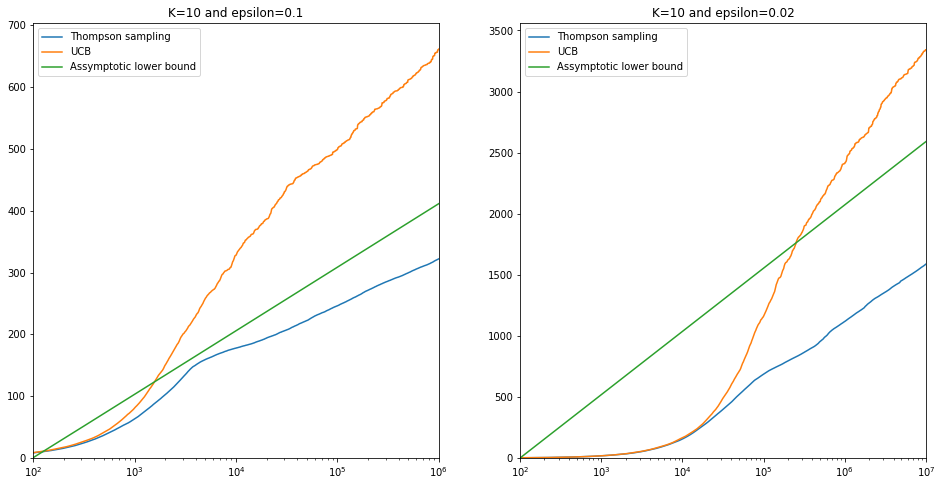

In [7]:
# plots!
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

# plot 1: Thompson sampling and UCB for epsilon = 0.1
ax1.plot(list(range(1,iterations[0])), cum_regret_thompson1[1:iterations[0]], label= 'Thompson sampling')
ax1.plot(list(range(1,iterations[0])), cum_regret_UCB1[1:iterations[0]], label= 'UCB')
ax1.plot(list(range(1,iterations[0])), l_bound1[1:iterations[0]], label= 'Assymptotic lower bound')
ax1.set_ylim(ymin=0)
ax1.set_xscale('log')
ax1.legend(loc='upper left')
ax1.set_title('K=10 and epsilon=0.1')
ax1.set_xlim([10**2, 10**6])


# plot 2: Thompson sampling and UCB for epsilon = 0.02
ax2.plot(list(range(1,iterations[1])), cum_regret_thompson2[1:iterations[1]], label= 'Thompson sampling')
ax2.plot(list(range(1,iterations[1])), cum_regret_UCB2[1:iterations[1]], label= 'UCB')
ax2.plot(list(range(1,iterations[1])), l_bound2[0:iterations[1]], label= 'Assymptotic lower bound')
ax2.set_ylim(ymin=0)
ax2.legend(loc='upper left')
ax2.set_title('K=10 and epsilon=0.02')
ax2.set_xscale('log')
ax2.set_xlim([10**2, 10**7])


plt.show()